# Modeling C-Suites 

This is going to be a demo of the modeling process from start to finish. We are going to take in all of the learnings from our last session and apply them. We will talk through some of the methods and places where the process could be improved. We are going to be modeling C-Suites. Recall the data science workflow from our last session:

* Problem Identification
* Data Gathering
* Data Cleaning
* Exploration
* Feature Engineering
* Normalizations and Transformations
* Model
* Validate
* Deploy/Interpret

It might not be possible to demonstrate each step in a single session to we may need to cover this demo in two sessions. We will see. Lets break down what we have so far. 

## Problem Identification
What - We want to create a platform segment of modeled CSuites 
How - Using Bombora's third party, we will build and validate a classification model where our target/label variable are C-Suites or Non-CSuites. We will then deploy our model against a Non-Labeled data subset and create a platform segment based off some scoring using our best model. We will push this segment back to BQ (Deployment) and follow the platform segment steps. 

## Data Gathering 
We will use Bombora's CSuite datapoint to create a label vector of users who are known CSuite. We will define the label to be a 1 if user is CSuite and 0 otherwise. We will then grab 1st party data points for each of the users joining on user ID. Each feature has been filtered to only include those which have at least 2 page views or more. 

SQL: https://github.com/vindication09/Clustering-/blob/master/Notebook_lessons/CSUITES%20blackbox%20modeling%20demo.sql

## Data Cleaning 
We applied some initial data cleaning in the above step. We made sure a user could only have one label. We also removed features which were empty and null. We next need to convert the data from wide to long format by making each categorical value a dummy variable. 

Lets bring in the packages we will be using to carry out this workflow and bring in the data from our tables in BigQuery.

In [22]:
from google.cloud import bigquery

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

import category_encoders as ce

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification

from sklearn.ensemble import ExtraTreesClassifier

from numpy import unique

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.naive_bayes import BernoulliNB

import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report,precision_score

In [2]:
client = bigquery.Client(location="US")

print("Client creating using default project: {}".format(client.project))

query = """
    SELECT *
    FROM `media-data-science.Haro_Work.aprmay_csuites_modelingdata`
    """

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


df = query_job.to_dataframe()

Client creating using default project: media-data-science


The following code will check missing data. We should not have any missing data since we accounted for that in the SQL. We will also look at some of the metdata such as number of rows and columns. 

As part of our cleaning, we will also go ahead and make every value a dummy column. Keep in mind that this will greatly increase the dimension of your dataframe but at this point, I do not anticipate us keeping many of the variables. We will not use dummy variables for the EDA portion but rather to jeep on the side for when we start modeling. 

In [3]:
df.head()

,target,value
0,0,law
1,0,business/news/graphics
2,0,farming
3,0,taxes
4,0,stocks


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4328 entries, 0 to 4327
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  4328 non-null   int64 
 1   value   4328 non-null   object
dtypes: int64(1), object(1)
memory usage: 67.8+ KB


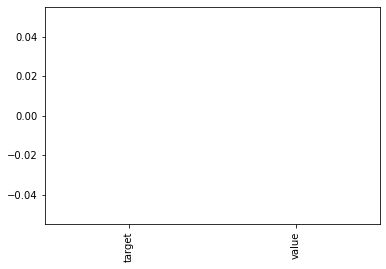

In [5]:
df.isnull().sum().plot(kind="bar")

In [6]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)

df_dum = ohe.fit_transform(df)

df_dum.head()


,target,value_law,value_business/news/graphics,value_farming,value_taxes,value_stocks,value_markets/cic/public,value_solar-energy,value_content-storythread,value_bloomberg/audio/home/dc,...,value_topicpage-Tax Evasion,value_authorpage-ARBOgwBc2RIjackieedwards,value_authorpage-AOl_VVBlN4Egregorylarkin,value_authorpage-AQgXoqAi4I0kitchellel,value_business/news/home/index,value_authorpage-AUHPsRzT7d0emmavickers,value_sectionfront-futureofbusinesstechnologyandwork,value_authorpage-AQdON9KpZn8jeffsutherland,value_gulf-coast,value_business/topic/CL
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA + Feature Removal

Lets start exploring our dataset and see what we can learn from these data points. 

In [7]:
count_test=len(df_dum[df_dum['target']==1])

count_control=len(df_dum[df_dum['target']==0])

pct_test=count_test/(count_test+count_control)

pct_control=count_control/(count_test+count_control)

print("Percent of CSuites", round(pct_test*100, 2))

print("Percent of Non CSuites", round(pct_control*100, 2))

Percent of CSuites 33.6
Percent of Non CSuites 66.4


Roughly 34 percent of target variables are associated with CSUITES vs 66% Non CSUITES. The data is not terribly imbalanced so I do not believe that we need to apply methods such as synthetic minority oversampling technique. 

Given that we already dummified our data, our EDA options are limited. We now have thousands of columns and it will be tedious to go through each column one by one. What we can do instead is to pick modeling methods that do not have such strict assumptions as a logistic regression. We still have the ability to remove features. Feature importance by decision trees is one method. We can also remove highly correlated features. Dropping features is an essential part of the modeling process to avoid running into problems with dimensionality. 

Lets first remove highly correlated predictors. Before removing highly correlated predictors, I am going to split my dataset into X subset for variables and Y dataset for target variable. This is something that python requires. I believe its done this way in order to enhance operation speed. This is another example when packages are maintained by computer scientists vs statasticians. In R, we define the explicit model using Y~X1+X2... 

In [30]:
#Splitting the target vector from the feature matrix is a syntax requiremen. This is not done in r

X=df_dum.drop(columns='target')

Y=df_dum['target'].copy() 

X.shape


(4328, 2961)

In [31]:
Y.describe()

count    4328.000000
mean        0.335952
std         0.472377
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [32]:
# Create correlation matrix
corr_matrix = X.corr().abs()
#print(); print(corr_matrix)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(np.bool))
#print(); print(upper)

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
#print(); print(to_drop)

to_drop

[]

In [33]:
# Drop Marked Features
X1 = X.drop(X.columns[to_drop], axis=1)
#print(); print(X1)
X1.shape

(4328, 2961)

Based on our output, there was no change in the number of features. This could only mean that there are no highly correlated predcitors at the moment. I will bypass using zero variance feature removal as well since we know through experience that data points such as adcode or brand are almost always varied in terms of number of unique values. We might need to build some initial models AND then view influential features to start removing features. In order to clear up some memory, we will delete X1. 

In [34]:
del X1 

## Benchmark Modeling 

We are going to build initial models using the data as is. These will be benchmark models. The purpose here is to get a baseline accuracy per model so we can pick which model to focus on for parameter tunning and feature removal. 

We are going to split our data into a training and test set using an 80/20 ratio. That means we are going to train our model on 80 percent of the data and use the remaining 20 percent to test our model performance. Once we feel happy enough with our models, we will deploy them against a validiation training set which are visitors from the month of June. The goal is to create a platform segment if modeled users using our best performing model. 

Note: Random State=42 is a Pseudo-random number that makes sure the data is split in the same way every time this code is run, otherwise we could get different results. The choice of random number is mostly arbitrary. I picked 42 because that is the meaning of life. 

We are going to try several classification models and then choose to improve the model which shows the highest accuracy when tested against the test data. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

### Naive - Bayes 

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       884
           1       1.00      0.00      0.00       415

    accuracy                           0.68      1299
   macro avg       0.84      0.50      0.40      1299
weighted avg       0.78      0.68      0.55      1299



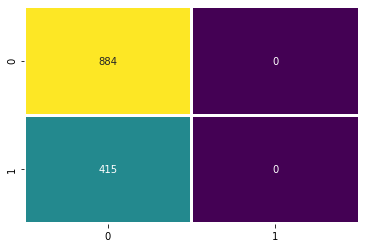

In [43]:
# Naive Bayes

gnb = BernoulliNB()

nb_pred = gnb.fit(X_train, y_train).predict(X_test)

print(metrics.classification_report(y_test, nb_pred,zero_division=1))

sns.heatmap(confusion_matrix(y_test,nb_pred),cmap="viridis",lw = 2,annot=True,cbar=False, fmt='g')

Naive Bayes model had an accuracy of 0.08 percent. This is considered to be very poor performing in term of accuracy. Lets take a moment and understand everything that is going on. 

Accuracy is the overall measure of correct predicitions. 

Precision is the measure of labeling data as CSuite even though they were not.  

Recall is the percent of correct CSuites did our model catch. 

F1 is what percent of CSuites did we predict correctly. 

Our confusion matrix reveals that we did not classify a single row as non CSuite. We correctly predicted 65 rows as CSuites. We incorrectly predicted 212 non CSuites as CSuites and incorrectly predicted 589 Non CSuites as CSuites. 

Note: Predicted would be the "x axis" and actuals are the " y axis". This is default. 

### Logisitc Regression

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       884
           1       1.00      0.00      0.00       415

    accuracy                           0.68      1299
   macro avg       0.84      0.50      0.40      1299
weighted avg       0.78      0.68      0.55      1299



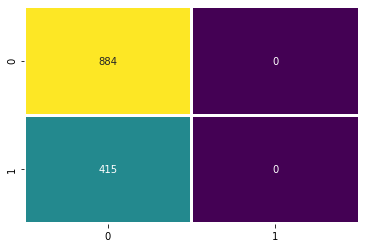

In [42]:
reg_log = LogisticRegression()

reg_log.fit(X_train, y_train)

log_pred = reg_log.predict(X_test)

print(metrics.classification_report(y_test, log_pred, zero_division=1))

sns.heatmap(confusion_matrix(y_test,log_pred),cmap="viridis",lw = 2,annot=True,cbar=False, fmt='g')

Even though we get an overall accuracy of 68 percent, the mathematics behind logisitc regression seem to be failing. This could be due dimensionality. We probably will need to use PCA dimension reduction or AIC backfitting (computationally heavy) if we want to continue using this model. Our results say that we are not able to predict any CSuites using logisitc regression. 

### Random Forest 

              precision    recall  f1-score   support

           0       0.58      0.65      0.62       884
           1       0.00      0.00      0.00       415

    accuracy                           0.44      1299
   macro avg       0.29      0.33      0.31      1299
weighted avg       0.40      0.44      0.42      1299



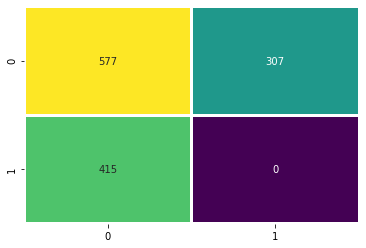

In [44]:
reg_rf = RandomForestClassifier()

reg_rf.fit(X_train, y_train)

rf_pred = reg_rf.predict(X_test)

print(metrics.classification_report(y_test, rf_pred))

sns.heatmap(confusion_matrix(y_test,rf_pred),cmap="viridis",lw = 2,annot=True,cbar=False, fmt='g')

### SVM

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       884
           1       0.00      0.00      0.00       415

    accuracy                           0.44      1299
   macro avg       0.29      0.33      0.31      1299
weighted avg       0.40      0.44      0.42      1299



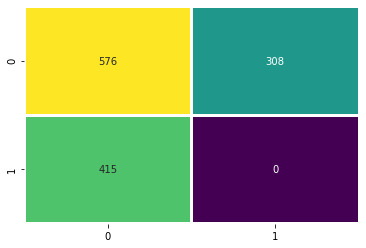

In [45]:
reg_svc = SVC()

reg_svc.fit(X_train, y_train)

svm_pred = reg_svc.predict(X_test)

print(metrics.classification_report(y_test, svm_pred))

sns.heatmap(confusion_matrix(y_test,svm_pred),cmap="viridis",lw = 2,annot=True,cbar=False, fmt='g')

### KNN

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       884
           1       0.30      0.16      0.21       415

    accuracy                           0.61      1299
   macro avg       0.49      0.49      0.48      1299
weighted avg       0.56      0.61      0.57      1299



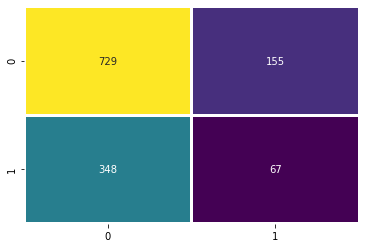

In [46]:
reg_knn = KNeighborsClassifier()

reg_knn.fit(X_train, y_train)

knn_pred = reg_knn.predict(X_test)

print(metrics.classification_report(y_test, knn_pred))

sns.heatmap(confusion_matrix(y_test,knn_pred),cmap="viridis",lw = 2,annot=True,cbar=False, fmt='g')

### For Next Time...

Lets recap what we did here. We wrote some SQL that cleaned up the data by removing missing values, assigned label vector to each data point, and merged several features together. We then imported the data into our python enviorment. We examined the steps required to reshape the data into a form that is compatible with SKLearn. We build some benchmark models. There are benchmark models due to the fact that we did not do any statistical feature selecton yet. We simply want a base reading on how different models perform before we do a deep dive into statsitical feature selection. 

We need to evaluate:

- Hyper parameter tunning (Max depgh of a tree, number of layers in a nueral network, learning rate threshold for gradient decent, or number of k clusters) 

- Rigorous Feature Selection 

- potentially adding cross validation 

- Re-Run models and pick the best performing 

- Make predictions 

- Save the best performing model as a "pickle" object 

- deploy model against validation data and score predictions to generate platform segment of modeled CSUITES 